In [1]:
### imports

# external modules
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import importlib
import time
import copy
import random

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import json_utils as jsonu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
import refruns_utils as rru
importlib.reload(csvu)
importlib.reload(jsonu)
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)
importlib.reload(rru)
sys.path.append('../src')
sys.path.append('../src/classifiers')
sys.path.append('../src/cloudfitters')
import HistStruct
importlib.reload(HistStruct)
import SubHistStruct
importlib.reload(SubHistStruct)
import DataLoader
importlib.reload(DataLoader)
import AutoEncoder
importlib.reload(AutoEncoder)
import SeminormalFitter
import GaussianKdeFitter
import HyperRectangleFitter
importlib.reload(SeminormalFitter)
importlib.reload(GaussianKdeFitter)
importlib.reload(HyperRectangleFitter)

2022-06-21 22:35:13.631683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.

<module 'HyperRectangleFitter' from '/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/KH-AutoencoderTest/../src/cloudfitters/HyperRectangleFitter.py'>

In [2]:
### Function to prep data for combined autoencoder
# This function may need alteration if using a concatenate layer
def prep_combine_hists(histnames):
    
    if readnew:
        
        # Initializations
        dloader = DataLoader.DataLoader()
        dataframes = []
        
        # Loop over eras
        for era in eras:
            # Loop over histogram types to initiate merge where needed
            if userfriendly:
                print('Processing data for era ' + str(era))
            for histnamels in histnames:
                if userfriendly:
                    print('Adding {}...'.format(histnamels))
                # Combine any desired histograms into 1D
                df = prep_1D_df(histnamels, era)
                # Store histograms
                dataframes.append(df)
        if userfriendly:
            print('Autoencoders to train: ' + str(len(dataframes)))
    # Currently unavailble functionality 
#    if save:
#        histstruct.save( 'test.pkl' )
#        
#    if not readnew:
#        histstruct = HistStruct.HistStruct.load( 'test.pkl' )
#        nbadruns = len([name for name in list(histstruct.masks.keys()) if 'bad' in name])
#
#    print('Created a histstruct with the following properties:')
#    print('- number of histogram types: {}'.format(len(histstruct.histnames)))
#    print('- number of lumisections: {}'.format(len(histstruct.lsnbs)))
#    print('- masks: {}'.format(list(histstruct.masks.keys())))
    
    return dataframes

In [3]:
### Function to prep dataframe for 1D autoencoder
# This function may soon be obsoleted by using a concatenate layer in the neural network
def prep_1D_df(histnamels, era):
    
    # Creates a list of csv filenames for the histograms
    csv_names = []
    for histname in histnamels:
        filename = datadir + year + era + '/DF' + year + era + '_' + histname + '.csv'
        csv_names.append(filename)
    
    # Combines the CSV files into a single dataframe
    df1 = csvu.read_and_merge_csv(csv_names, userfriendly)
    
    
    # Stitch the histograms together into a single 1D histogram
    df1 = dfu.merge_ls(df1)
    df1.reset_index(drop=True,inplace=True)
    
    
    # Print information about the data
    if(userfriendly): print('\nRaw input data shape: {}'.format( dfu.get_hist_values(df1)[0].shape))
    
    # Filter the dataset to have DCS-bit on and high statistics
    # df2 = dfu.select_dcson(df2)
    # if userfriendly: print('Number of passing lumisections after DCS selection: {}'.format( len(df2) ))
    # 
    # df2 = dfu.select_highstat(df2,entries_to_bins_ratio=100)
    # if userfriendly: print('Number of passing lumisections after high statistics selection: {}\n'.format( len(df2)))
        
    return df1

In [4]:
### Prepare Input Data
def prep_input_data(dataframes):
    
    if readnew:
        # Define a HistStruct object for data flow organization
        histstruct = HistStruct.HistStruct()
        if userfriendly: print('Created HistStruct')
        
        rebinningfactor = 1
        
        # Convert dataframes into histograms and store in histstruct
        iterate = 0
        for df in dataframes:
            if userfriendly: print('Preparing data from dataframe ' + str(iterate))
            
            # In case of local/development training, we can remove most of the histograms
            if( runsls_training is not None and runsls_good is not None and runsls_bad is not None ):
                runsls_total = {k: v for d in (runsls_training, runsls_good, runsls_bad) for k, v in d.items()}
                df = dfu.select_runsls( df, runsls_total )
    
            # Add histogram to histstruct
            histstruct.add_dataframe(df)
            iterate = iterate + 1
        if userfriendly: print('found {} histograms'.format(len(histstruct.runnbs)))   
            
        # Add masks
        histstruct.add_dcsonjson_mask( 'dcson' )
        histstruct.add_goldenjson_mask('golden' )
        histstruct.add_highstat_mask( 'highstat' )
        histstruct.add_stat_mask( 'lowstat', max_entries_to_bins_ratio=100 )
        if runsls_training is not None: histstruct.add_json_mask( 'training', runsls_training )
        if runsls_good is not None: histstruct.add_json_mask( 'good', runsls_good )
            
        # Distinguishing bad runs
        nbadruns = 0
        if runsls_bad is not None:
            print(runsls_bad)
            histstruct.add_json_mask( 'bad', runsls_bad )
            
            # Special case for bad runs: add a mask per run (different bad runs have different characteristics)
            nbadruns = len(runsls_bad.keys())
            for i,badrun in enumerate(runsls_bad.keys()):
                histstruct.add_json_mask( 'bad{}'.format(i), {badrun:runsls_bad[badrun]} )
            
            
        # Save histstruct if specified
        if save:
            histstruct.save('test.pk1')
    
    # Load existing histstruct
    if not readnew:
        histstruct = HistStruct.HistStruct.load( 'test.pkl' )
        nbadruns = len([name for name in list(histstruct.masks.keys()) if 'bad' in name])
    
    # Inform user
    if userfriendly:
        print('Defined a histstruct with the following properties:')
        print('- number of histogram types: {}'.format(len(histstruct.histnames)))
        print('- number of lumisections: {}'.format(len(histstruct.lsnbs)))
        print('- masks: {}'.format(list(histstruct.masks.keys())))
    
    return [histstruct, nbadruns]

In [5]:
def define_concatamash_autoencoder(histstruct):
    
    histslist = []
    vallist = []
    autoencoders = []
    if trainnew:
        for i,histnamegroup in enumerate(histnames):
            
            train_normhist = np.array([hu.normalize(histstruct.get_histograms(
                histname = hname, masknames = ['dcson','highstat', 'training']), 
                                                 norm="l1", axis=1) 
                                       for hname in histnamegroup]).transpose((1,0,2))
            X_train, X_val = train_test_split(train_normhist, test_size=0.4, random_state=42)
            
            if userfriendly:
                print('\nNow Defining model {}/'.format(i + 1) 
                      + str(len(histnames)))
                print(' - Size of training set: {}'.format(X_train.shape))
            
            # Half the total bin count
            arch = 51 * len(histnamegroup)
            
            ## Model parameters
            print(X_train.shape)
            
            input_dim = X_train.shape[2] #num of predictor variables
            Input_layers=[Input(shape=input_dim) for i in range((X_train.shape[1]))]
            
            # Defining layers
            conc_layer = Concatenate()(Input_layers)
            encoder = Dense(arch * 2, activation="tanh")(conc_layer)
            #encoder = Dense(128, activation='relu')(encoder)
            #
            #encoder = Dense(32, activation='relu')(encoder)
            
            decoder = Dense(arch, activation="relu")(encoder)
            #decoder = Dense(256, activation="tanh")(decoder)
            
            Output_layers=[Dense(input_dim, activation="tanh")(decoder) for i in range(X_train.shape[1])]

            autoencoder = Model(inputs=Input_layers, outputs=Output_layers)
            autoencoder.summary()
            autoencoders.append(autoencoder)
            
            histslist.append(X_train)
            vallist.append(X_val)
     
    # Return the histograms stored 2-Dimensionally and the autoencoders corresponding
    return(histslist, vallist, autoencoders, train_normhist)

In [6]:
def train_1DMash_autoencoder(histstruct):
    
    trainnew = True
    save = False
    modelloc = '../models/autoencoders_global_training_dcson_highstat_v20210622'
    modelbasename = ''
    
    if trainnew:
        for i,histname in enumerate(histstruct.histnames):
            # Choose training set
            if training_mode != 'development':
                hists = histstruct.get_histograms( histname=histname, masknames=['dcson','highstat'] )
            else:
                hists = histstruct.get_histograms( histname=histname, masknames=['dcson','highstat', 'training'] )
            
            if userfriendly:
                print('\nNow training model {}/'.format(i+1) 
                      + str(len(histstruct.histnames)))
                print(' - Size of training set: {}'.format(hists.shape))
            
            # Model parameters
            input_size = hists.shape[1]
            arch = [int(hists.shape[1]/2.)]
            act = ['tanh']*len(arch)
            opt = 'adam'
            loss = aeu.mseTop10
            if userfriendly: 
                verbose = 1 
                print(str(hists.shape))
            else: verbose = 0
            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
            
            # Model creation and training
            autoencoder = aeu.getautoencoder(input_size,arch,act,opt,loss)
            history = autoencoder.fit(hists, hists, epochs=200, batch_size=20, shuffle=True, verbose=verbose, validation_split=0.1, callbacks=[callback])
            
            # Create a plot of the model
            if createPlots:
                tf.keras.utils.plot_model(
                    autoencoder,
                    to_file="models/model1D{}.png".format(i),
                    show_shapes=True,
                    show_dtype=False,
                    show_layer_names=False,
                    rankdir="TB")
            
            # Save the models
            classifier = AutoEncoder.AutoEncoder(model=autoencoder)
            histstruct.add_classifier(histname, classifier)
        
    else:
        from autoencoder_utils import mseTop10
        for histname in histstruct.histnames:
            print('loading model for {}'.format(histname))
            modelpath = modelbasename+'_'+histname+'.h5'
            modelpath = os.path.join(modelloc,modelpath)
            classifier = AutoEncoder.AutoEncoder( modelpath=modelpath )
            histstruct.add_classifier(histname,classifier)
    return histstruct

In [7]:
### Trains a combined autoencoder for every merge set
def train_concatamash_autoencoder(histstruct, histslist, vallist, autoencoders):
    
    # Iterate through the training data to train corresponding autoencoders
    for i in range(len(histslist)):
        
        if userfriendly: print('\nNow training model {}/'.format(i + 1) + str(len(histslist)))
        
        # Set variables to temporary values for better transparency
        X_train = histslist[i]
        X_val = vallist[i]
        autoencoder = autoencoders[i]
        
        
        ## Model parameters
        nb_epoch = 200
        batch_size = 50
        
        #checkpoint_filepath = 'checkpoint'
        #model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        #   filepath=checkpoint_filepath,
        #   save_weights_only=False,
        #   verbose=1,
        #   save_best_only=True,
        #   monitor='val_loss',
        #   mode='min')
        
        # Tell the model when to stop
        earlystop = EarlyStopping(monitor='val_loss',
            min_delta=1e-7,
            patience=20,
            verbose=1,
            mode='auto',
            baseline=None,
            restore_best_weights=True,
        )
        lr =0.001
        opt = keras.optimizers.Adam(learning_rate=lr)
        
        autoencoder.compile(loss='mse',
                            optimizer=opt)
        
        ## Train autoencoder
        train = autoencoder.fit(x=[X_train[:,i] for i in range(X_train.shape[1])],
                                y=[X_train[:,i] for i in range(X_train.shape[1])],
                            epochs=nb_epoch,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=([X_val[:,i] for i in range(X_val.shape[1])], [X_val[:,i] for i in range(X_val.shape[1])]),
                            verbose=1,
                                callbacks= [earlystop] 
                            )
        
        # Create a plot of the model
        
        tf.keras.utils.plot_model(
            autoencoder,
            to_file="models/modelConcatamash{}.png".format(i),
            show_shapes=True,
            show_dtype=False,
            show_layer_names=False,
            rankdir="TB")
        
        # Save classifier for evaluation
        classifier = AutoEncoder.AutoEncoder(model=autoencoder)
        histstruct.add_classifier(histnames[i][0], classifier)    
        
    return histstruct

In [8]:
def train_combined_autoencoder(histstruct2):
    for histname in histstruct2.histnames:
        hists = histstruct2.get_histograms( histname=histname, masknames=['dcson','highstat','training'] )
        print('size of training set: {}'.format(hists.shape))
        # choose whether to save the model
        ## modelname = modelbasename+'_'+histname+'.h5'
        ## modelname = os.path.join(modelloc,modelname)
        ## if not save: modelname = '' # empty string means do not save models
        ## nepochs = 40 # manual number of epochs
        ## model = aeu.train_simple_autoencoder(hists,nepochs=nepochs,modelname=modelname,
         #                                   batch_size=2000
         #                                   )
        
        # Model parameters
        input_size = hists.shape[1]
        arch = [int(hists.shape[1]/2.)]
        act = ['tanh']*len(arch)
        opt = 'adam'
        loss = aeu.mseTop10
        verbose = 1 
        print(str(hists.shape))
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
        
        # Model creation and training
        autoencoder = aeu.getautoencoder(input_size,arch,act,opt,loss)
        history = autoencoder.fit(hists, hists, epochs=200, batch_size=50, shuffle=True, verbose=verbose, validation_split=0.1, callbacks=[callback])
        
        # Save the models
        classifier = AutoEncoder.AutoEncoder(model=autoencoder)
        histstruct2.add_classifier(histname, classifier)
        
        ## classifier = AutoEncoder.AutoEncoder( model=model )
        ## histstruct.add_classifier(histname,classifier)
    return histstruct2

In [9]:
def evaluate_combine_models_train(histstruct2):
    for histname in histstruct2.histnames:
        histstruct2.evaluate_classifier(histname)
    
    # get mse for training set
    if 'training' in histstruct2.masks.keys(): masknames = ['dcson','highstat', 'training']
    else: masknames = ['dcson','highstat']
    mse_train = histstruct2.get_scores_array( masknames=masknames )
    print('Found mse array for training set of following shape: {}'.format(mse_train.shape))
    
    # get mse for good set
    if 'good' in histstruct2.masks.keys():
        mse_good = []
        for histname in histstruct2.histnames:
            mse_good.append(histstruct2.get_scores( histname=histname, masknames=['dcson','highstat','good'] ))
    else:
        mse_good = []
        for histname in histstruct2.histnames:
            hists_good = hu.averagehists( histstruct2.get_histograms( histname=histname, masknames=['dcson','highstat']), 1000 )
            thismse = histstruct2.classifiers[histname].evaluate( hists_good )
            mse_good.append( thismse )
            print(run)
    mse_good = np.array(mse_good)
    mse_good = np.transpose(mse_good)
    print('Found mse array for good set of following shape: {}'.format(mse_good.shape))
    
    # get mse for bad sets
    mse_bad = []
    for i in range(nbadruns):
        mse_bad.append( histstruct2.get_scores_array( masknames=['dcson','highstat','bad{}'.format(i)] ) )
        print('Found mse array for bad set of following shape: {}'.format(mse_bad[i].shape))
        
    return [mse_train, mse_good, mse_bad]

In [10]:
### Evaluate the Models for WP definition
def evaluate_models_train(histstruct):
    
    for histgroup in histnames:
        print('evaluating model for '+histgroup[0])
        print(histstruct.evaluate_classifier(histgroup)[0].shape)
    
    # get mse for training set
    if 'training' in histstruct.masks.keys(): masknames = ['dcson','highstat', 'training']
    else: masknames = ['dcson','highstat']
    mse_train = histstruct.get_scores_array( masknames=masknames )
    print('Found mse array for training set of following shape: {}'.format(mse_train.shape))
    
    # get mse for good set
    if 'good' in histstruct.masks.keys():
        mse_good = []
        for histname in histstruct.histnames:
            mse_good.append(histstruct.get_scores( histname=histname, masknames=['dcson','highstat','good'] ))
    else:
        mse_good = []
        for histname in histstruct.histnames:
            hists_good = hu.averagehists( histstruct.get_histograms( histname=histname, masknames=['dcson','highstat']), 1000 )
            thismse = histstruct.classifiers[histname].evaluate( hists_good )
            mse_good.append( thismse )
            print(run)
    mse_good = np.array(mse_good)
    mse_good = np.transpose(mse_good)
    print('Found mse array for good set of following shape: {}'.format(mse_good.shape))
    
    # get mse for bad sets
    mse_bad = []
    for i in range(nbadruns):
        mse_bad.append( histstruct.get_scores_array( masknames=['dcson','highstat','bad{}'.format(i)] ) )
        print('Found mse array for bad set of following shape: {}'.format(mse_bad[i].shape))
        
    return [mse_train, mse_good, mse_bad]

In [11]:
### Evaluate the Models for WP definition
def evaluate_models_train_1DMash(histstruct):
    
    for histgroup in histnames:
        print('evaluating model for '+histgroup[0])
        histstruct.evaluate_classifier(histgroup[0])
    
    # get mse for training set
    if 'training' in histstruct.masks.keys(): masknames = ['dcson','highstat', 'training']
    else: masknames = ['dcson','highstat']
    mse_train = histstruct.get_scores_array( masknames=masknames )
    print('Found mse array for training set of following shape: {}'.format(mse_train.shape))
    
    # get mse for good set
    if 'good' in histstruct.masks.keys():
        mse_good = []
        for histname in histstruct.histnames:
            mse_good.append(histstruct.get_scores( histname=histname, masknames=['dcson','highstat','good'] ))
    else:
        mse_good = []
        for histname in histstruct.histnames:
            hists_good = hu.averagehists( histstruct.get_histograms( histname=histname, masknames=['dcson','highstat']), 1000 )
            thismse = histstruct.classifiers[histname].evaluate( hists_good )
            mse_good.append( thismse )
            print(run)
    mse_good = np.array(mse_good)
    mse_good = np.transpose(mse_good)
    print('Found mse array for good set of following shape: {}'.format(mse_good.shape))
    
    # get mse for bad sets
    mse_bad = []
    for i in range(nbadruns):
        mse_bad.append( histstruct.get_scores_array( masknames=['dcson','highstat','bad{}'.format(i)] ) )
        print('Found mse array for bad set of following shape: {}'.format(mse_bad[i].shape))
        
    return [mse_train, mse_good, mse_bad]

In [12]:
### Plots and Distribution Analysis
def fit_mse_distribution(histstruct, mse_train):
    dimslist = []
    fitfunclist = []
    
    
    nhisttypes = len(histstruct.histnames)
    for i in range(0,nhisttypes-1):
        for j in range(i+1,nhisttypes):
            dimslist.append((i, j))
    
    plt.close('all')
    (npoints,ndims) = mse_train.shape
    
    
    # settings for GaussianKdeFitter
    scott_bw = npoints**(-1./(ndims+4))
    bw_method = 20*scott_bw
    # settings for HyperRectangleFitter
    quantiles = ([0.00062,0.0006,0.00015,0.00015,
                 0.0003,0.0003,0.00053,0.00065])
    
    
    for dims in dimslist:
        thismse = mse_train[:,dims]
        if training_mode=='global': 
            fitfunc = SeminormalFitter.SeminormalFitter(thismse)
            #fitfunc = HyperRectangleFitter.HyperRectangleFitter(thismse, 
            #                                                    [quantiles[dims[0]],quantiles[dims[1]]],
            #                                                    'up')
        else: fitfunc = GaussianKdeFitter.GaussianKdeFitter(thismse,bw_method=bw_method)
        #pu.plot_fit_2d(thismse, fitfunc=fitfunc, logprob=True, clipprob=True,
        #                onlycontour=False, xlims=30, ylims=30, 
        #                onlypositive=True, transparency=0.5,
        #                xaxtitle=histstruct.histnames[dims[0]], 
        #                yaxtitle=histstruct.histnames[dims[1]],
        #                title='density fit of lumisection MSE')
        ##plt.close('all') # release plot memory
        fitfunclist.append(fitfunc)
     
        
    if training_mode=='global': 
        fitfunc = SeminormalFitter.SeminormalFitter(mse_train)
        #fitfunc = HyperRectangleFitter.HyperRectangleFitter(mse_train, quantiles, 'up')
    else: fitfunc = GaussianKdeFitter.GaussianKdeFitter(mse_train,bw_method=bw_method)
    
    return fitfunc

In [13]:
### Prepare MSEs for Working Point Definition
def mse_analysis(histstruct, mse_good_eval, mse_bad_eval, fitfunc):
    
    # Get the minimum log probability of histograms in good set
    print('--- good lumesections ---')
    logprob_good = np.log(fitfunc.pdf(mse_good_eval))
    print('length of log prob array: '+str(len(logprob_good)))
    print('minimum of log prob: '+str(np.min(logprob_good)))
    #print(sorted(logprob_good))
    
    print('--- bad lumisections ---')
    logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]
    #for lp in logprob_bad_parts: print(str(sorted(lp))+'\n\n')
    logprob_bad = np.concatenate(tuple(logprob_bad_parts))
    
    print('length of log prob array: '+str(len(logprob_bad)))
    print('maximum of log prob: '+str(np.max(logprob_bad)))
    #print(sorted(logprob_good))
    #print(sorted(logprob_bad))
    #print(logprob_bad)
    
    return [logprob_good, logprob_bad]

In [14]:
### MAIN
def main(start, histstruct, histstruct2, biasFactor):
    concatamashTimes = []
    combinedTimes = []
    # Concatamash/Combine
    stop = time.perf_counter()
    
    print('Concatamash preprocess time: ' + str((stop - start)/2))
    print('Combine preprocess time: ' + str((stop - start)/2))
    concatamashTimes.append((stop - start)/2)
    combinedTimes.append((stop - start)/2)
    
    # 1D Mash
    oneDMashTimes = []
    start = time.perf_counter()
    # Output suppression
    save_stdout = sys.stdout
    sys.stdout = open('trash', 'w')
    # Preprocess step
    dataframes = prep_combine_hists(histnames)
    (histstruct1, nbadruns) = prep_input_data(dataframes)
    # Restore output
    sys.stdout = save_stdout
    stop = time.perf_counter()
    print('1D Mash preprocess time: ' + str(stop - start))
    oneDMashTimes.append((stop - start))
    
    # Concatamash
    start = time.perf_counter()
    # Output suppression
    save_stdout = sys.stdout
    sys.stdout = open('trash', 'w')
    (histslist, vallist, autoencoders, train_normhist) = define_concatamash_autoencoder(histstruct)
    histstruct = train_concatamash_autoencoder(histstruct, histslist, vallist, autoencoders)
    # Restore output
    sys.stdout = save_stdout
    stop = time.perf_counter()
    print('Concatamash training time: ' + str(stop - start))
    concatamashTimes.append((stop - start))
    
    # Combine
    start = time.perf_counter()
    # Output suppression
    save_stdout = sys.stdout
    sys.stdout = open('trash', 'w')
    histstruct2 = train_combined_autoencoder(histstruct2)
    sys.stdout = save_stdout
    stop = time.perf_counter()
    print('Combined Autoencoder training time: ' + str(stop - start))
    combinedTimes.append((stop - start))
    
    # 1D Mash
    start = time.perf_counter()
    # Output suppression
    save_stdout = sys.stdout
    sys.stdout = open('trash', 'w')
    histstruct1 = train_1DMash_autoencoder(histstruct1)
    # Restore output
    sys.stdout = save_stdout
    stop = time.perf_counter()
    print('1D Mash training time: ' + str(stop - start))
    oneDMashTimes.append((stop - start))
    
    print(id(histstruct))
    print(id(histstruct2))
    # Concatamash
    print('Evaluating Concatamash:')
    (mse_train, mse_good_eval, mse_bad_eval) = evaluate_models_train(histstruct)
    fitfunc = fit_mse_distribution(histstruct, mse_train)
    (logprob_good, logprob_bad) = mse_analysis(histstruct, mse_good_eval, mse_bad_eval, fitfunc)
    evaluate_autoencoders_combined(logprob_good, logprob_bad, biasFactor)
    
    # Combine
    print('Evaluating Combine:')
    # Output suppression
    save_stdout = sys.stdout
    sys.stdout = open('trash', 'w')
    (mse_train, mse_good_eval, mse_bad_eval) = evaluate_combine_models_train(histstruct2)
    fitfunc = fit_mse_distribution(histstruct2, mse_train)
    (logprob_good, logprob_bad) = mse_analysis(histstruct2, mse_good_eval, mse_bad_eval, fitfunc)
    # Restore output
    sys.stdout = save_stdout
    evaluate_autoencoders_combined(logprob_good, logprob_bad, biasFactor)
    
    # 1D Mash
    print('Evaluating 1D Mash:')
    # Output suppression
    save_stdout = sys.stdout
    sys.stdout = open('trash', 'w')
    (mse_train, mse_good_eval, mse_bad_eval) = evaluate_models_train_1DMash(histstruct1)
    fitfunc = fit_mse_distribution(histstruct1, mse_train)
    (logprob_good, logprob_bad) = mse_analysis(histstruct1, mse_good_eval, mse_bad_eval, fitfunc)
    # Restore output
    sys.stdout = save_stdout
    evaluate_autoencoders_combined(logprob_good, logprob_bad, biasFactor)
    
    print('Final Speed Metrics:')
    print('Preprocess time:')
    print('   - Concatamash: ' + str(concatamashTimes[0]))
    print('   - Combined: ' + str(combinedTimes[0]))
    print('   - 1DMash: ' + str(oneDMashTimes[0]))
    print('Training time:')
    print('   - Concatamash: ' + str(concatamashTimes[1]))
    print('   - Combined: ' + str(combinedTimes[1]))
    print('   - 1DMash: ' + str(oneDMashTimes[1]))

In [15]:
def evaluate_autoencoders_combined(logprob_good, logprob_bad, biasFactor):
    labels_good = np.zeros(len(logprob_good)) # background: label = 0
    labels_bad = np.ones(len(logprob_bad)) # signal: label = 1
    
    badMin = min(np.where(logprob_bad != -np.inf, logprob_bad, np.inf))
    goodMax = max(np.where(logprob_good != np.inf, logprob_good, -np.inf))
    
    # Getting rid of infinities
    logprob_good[logprob_good > 500] = goodMax
    logprob_bad[logprob_bad < 0] = badMin
    # These only take effect if a histogram is grossly misclassified
    logprob_good[logprob_good < badMin] = badMin
    logprob_bad[logprob_bad > goodMax] = goodMax
    
    labels = np.concatenate(tuple([labels_good,labels_bad]))
    scores = np.concatenate(tuple([-logprob_good,-logprob_bad]))
    scores = aeu.clip_scores( scores )
    
    pu.plot_score_dist(scores, labels, siglabel='anomalous', sigcolor='r', 
                       bcklabel='good', bckcolor='g', 
                       nbins=200, normalize=True,
                       xaxtitle='negative logarithmic probability',
                       yaxtitle='number of lumisections (normalized)')
      
    # Plot ROC curve for analysis
    auc = aeu.get_roc(scores, labels, mode='geom', doprint=False)
    
    # Setting a threshold, below this working point defines anomalous data
    # Average is biased towards better recall per user specifications
    logprob_threshold = (1/(biasFactor + 1)) * (biasFactor*np.mean(logprob_good) + np.mean(logprob_bad))
    # Or set manual
    # logprob_threshold = 424
    (_, _, _, tp, fp, tn, fn) = aeu.get_confusion_matrix(scores,labels,-logprob_threshold)
    print('Selected logprob threshold of ' + str(logprob_threshold))
    
    # Get metrics for analysis
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_measure = (1 + biasFactor * biasFactor) * ((precision * recall) / ((biasFactor * biasFactor * precision) + recall)) 
    
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F-Measure: ' + str(f_measure))
    
    return logprob_threshold

In [16]:
### Speed Controls and Run Mode

# Disables all plots for large datasets where speed is more important
createPlots = True

# Control for the notebook - turn off user-friendly mode to enable faster runtimes
userfriendly = True

In [17]:
### Data Controls and Selection - 1D Autoncoder

# The directory data is located in
datadir = '../data/'

# Select a list of good runs to train on in development training_mode
# Should be validated by eye
trainrunsls = {'2017B':{
                    "297057":[[-1]], 
                    "297099":[[-1]], 
                    "297101":[[-1]],
                    "297113":[[-1]], 
                    "297114":[[-1]], 
                    "297175":[[-1]],   # A decently clean histogram
                    "297177":[[-1]],
                    "297179":[[-1]], 
                    "297215":[[-1]],
                    "297218":[[-1]],
                    "297225":[[-1]],
                    "297296":[[-1]], 
                    "297411":[[-1]],
                    "297426":[[-1]],  
                    "297431":[[-1]],
                    "297434":[[-1]], 
                    "297468":[[-1]],
                    "297483":[[-1]],
                    "297486":[[-1]],
                    "297503":[[-1]],
                    "297557":[[-1]],
                    "297598":[[-1]],
                    "297604":[[-1]],   # A decently clean histogram
                    "297620":[[-1]],   # A decently clean histogram
                    "297659":[[-1]],   # An okay histogram
                    "297670":[[-1]],   # A decently clean histogram
                    "297674":[[-1]],
                    "297678":[[-1]],   # A particularly messy histogram
                    "297722":[[-1]],   # A decently clean histogram
                    "298997":[[-1]],
                    "299061":[[-1]],
                    "299065":[[-1]],   # A decently clean histogram
                    "299067":[[-1]],   # A decently clean histogram
                    "299096":[[-1]],
                    "299149":[[-1]],
                    "299178":[[-1]],   # A decently clean histogram
                    "299184":[[-1]],   # A particularly messy histogram
                    "299185":[[-1]],   # A decently clean histogram
                    "299327":[[-1]],
                    "299329":[[-1]], 
                    "299480":[[-1]]    # A decently clean histogram
                    },
               '2017C':{
                   
               },
              '2018':{ # needs to be re-checked, not guaranteed to be fully correct or representative.   
                  "315267":[[-1]] 
              }
}

# Select a list of good runs to test on in development training_mode
# Should be validated by eye
goodrunsls = {'2017B':{
                     "297057":[[-1]], 
                     "297099":[[-1]], 
                     "297101":[[-1]],
                     "297113":[[-1]], 
                     "297114":[[-1]], 
                     "297175":[[-1]],   # A decently clean histogram
                     "297177":[[-1]],
                     "297179":[[-1]], 
                     "297215":[[-1]],
                     "297218":[[-1]],
                     "297225":[[-1]],
                     "297296":[[-1]], 
                     "297411":[[-1]],
                     "297426":[[-1]],  
                     "297431":[[-1]],
                     "297434":[[-1]], 
                     "297468":[[-1]],
                     "297483":[[-1]],
                     "297486":[[-1]],
                     "297503":[[-1]],
                     "297557":[[-1]],
                     "297598":[[-1]],
                     "297604":[[-1]],   # A decently clean histogram
                     "297620":[[-1]],   # A decently clean histogram
                     "297659":[[-1]],   # An okay histogram
                     "297670":[[-1]],   # A decently clean histogram
                     "297674":[[-1]],
                     "297678":[[-1]],   # A particularly messy histogram
                     "297722":[[-1]],   # A decently clean histogram
                     "298997":[[-1]],
                     "299061":[[-1]],
                     "299065":[[-1]],   # A decently clean histogram
                     "299067":[[-1]],   # A decently clean histogram
                     "299096":[[-1]],
                     "299149":[[-1]],
                     "299178":[[-1]],   # A decently clean histogram
                     "299184":[[-1]],   # A particularly messy histogram
                     "299185":[[-1]],   # A decently clean histogram
                     "299327":[[-1]],
                     "299329":[[-1]], 
                     "299480":[[-1]]    # A decently clean histogram
                    },
              '2017C':{
                  
              },
              '2018':{ # needs to be re-checked, not guaranteed to be fully correct or representative.   
                  "315267":[[-1]] 
              }
}


badrunsls = {'2017B':
                {
                    "297048":[[-1]],
                    "297282":[[-1]],
                    "297283":[[-1]],
                    "297284":[[-1]],
                    "297287":[[-1]],
                    "297288":[[-1]],
                    "297289":[[-1]],
                    "299316":[[-1]],
                    "299317":[[-1]],
                    "299318":[[-1]],
                    "299324":[[-1]],
                    "299326":[[-1]],
                   # "301086":[[88,126]],
                   # "301086":[[89,89]],
                   # "303948":[[1710,1710]],
                    "297047":[[-1]], #close but, true bad for all 8
                    "297169":[[-1]], #true bad for all 8
                    "297211":[[-1]], #Reconstructs well
                    "299325":[[-1]], #Reconstructs well
                    "297664":[[-1]], #true bad for all 8
                    "299317":[[-1]], #true bad for all 8
                    "297169":[[-1]], #true bad for all 8
                    "297502":[[-1]]
                },
             '2017C':{
                 "300781":[[-1]], # bad for tracking (pixels were excluded.
                 "300079":[[-1]] # is bad for strips and then also for tracking
             },
            '2018': # needs to be re-checked, not guaranteed to be fully correct or representative.
                {
                #"317479":[[-1]],
                "317480":[[-1]],
                "317481":[[-1]],
                "317482":[[-1]],
                #"319847":[[1,35]]
            }}


# The year and eras being used
year = '2017'
eras = ['B']

# Create a list of histograms to include
# Pair histograms to be combined on the same line
histnames = [
    ['NormalizedHitResiduals_TIB__Layer__1', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__1', 'NormalizedHitResiduals_TIB__Layer__2', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__2',
     'NormalizedHitResiduals_TIB__Layer__3', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__3' , 'NormalizedHitResiduals_TIB__Layer__4', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__4'],
    ['chargeInner_PXLayer_1', 'chargeOuter_PXLayer_1'],
    ['chargeInner_PXLayer_2', 'chargeOuter_PXLayer_2'],
    ['chargeInner_PXLayer_3', 'chargeOuter_PXLayer_3'],
    ['chargeInner_PXLayer_4', 'chargeOuter_PXLayer_4'],
#    ['charge_PXDisk_+1', 'adc_PXDisk_+1'],
#    ['charge_PXDisk_-1', 'adc_PXDisk_-1'],
#    ['charge_PXDisk_+2', 'adc_PXDisk_+2'],
#    ['charge_PXDisk_-2', 'adc_PXDisk_-2'],
#    ['charge_PXDisk_+3', 'adc_PXDisk_+3'],
#    ['charge_PXDisk_-3', 'adc_PXDisk_-3'],
    ['NormalizedHitResiduals_TOB__Layer__1', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__1', 'NormalizedHitResiduals_TOB__Layer__2', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__2',
     'NormalizedHitResiduals_TOB__Layer__3', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__3' , 'NormalizedHitResiduals_TOB__Layer__4', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__4']
]

# Read new data or use previously saved data & should data be saved
readnew = True
save = False

In [18]:
### Define Run Properties - Combined Autoencoder
# in this cell all major run properties are going to be set,

# Set whether to train globally or locally or in a development/testing mode
training_mode = 'development'

# Selects whether to create a new histstruct or use a saved one
readnew = True

# Select whether to save a new histstruct
save = False

In [19]:
### Model Controls and Selection - 1D Autoencoder

plotNames = 'Test'
name = plotNames+'plots'

# Choose whether to train a new model or load one
trainnew = True
savemodel = True
modelname = plotNames

# Evaluate models seperately, as an ensemble, both, or neither
individualEval = True
ensembleEval = False

In [20]:
### Setting a bias factor
biasFactor = 20

In [21]:
### Define Training Mode Parameters - Combined Autoencoder
if training_mode == 'global':
    runsls_training = None # use none to not add a mask for training (can e.g. use DCS-bit on mask)
    runsls_good = None # use none to not add a mask for good runs (can e.g. use averages of training set)
    runsls_bad = badrunsls[year] # predefined bad runs
    print('selected runs/lumisections for training: all')
    
elif training_mode == 'local':
    # train locally on a small set of runs
    # - either on n runs preceding a chosen application run,
    # - or on the run associated as reference to the chosen application run.
    # - this only works for a single era
    
    for era in eras:
        available_runs = dfu.get_runs( dfu.select_dcson( csvu.read_csv('../data/DF'+year+era+'_'+histnames[0][0]+'.csv') ) )
        # Cherry picked really bad run
        run_application = 299316
        #run_application = 299317
        run_application_index = available_runs.index(run_application)
        # select training set
        usereference = False
        if usereference:
            run_reference = rru.get_reference_run( run_application, jsonfile='../utils/json_allRunsRefRuns.json' )
            if run_reference<0:
                raise Exception('no valid reference run has been defined for run {}'.format(run_application))
            runsls_training = jsonu.tuplelist_to_jsondict([(run_reference,[-1])])
        else:
            ntraining = 5
            offset = 0 # normal case: offset = 0 (just use 5 previous runs)
            
            # Selects the 5 previous runs for training
            runsls_training = jsonu.tuplelist_to_jsondict([(el,[-1]) for el in available_runs[run_application_index-ntraining-offset:run_application_index-offset]])
        #runsls_bad = badrunsls[year]
        #runsls_good = jsonu.tuplelist_to_jsondict([(run_application,[-1])])
        runsls_bad = jsonu.tuplelist_to_jsondict([(run_application,[-1])])
        runsls_good = runsls_training
        print('selected runs/lumisections for training: ')
        print(runsls_training)
        print('selected runs/lumisections as good test set:')
        print(runsls_good)
        print('selected runs/lumisections as bad test set:')
        print(runsls_bad)
        
elif training_mode == 'development':
    # train on a user-defined subset of runs
    
    # Select random runs to be used in training from the user-defined list
    trainls = {}
    trainlist = []
    for run in trainrunsls['2017B']:
        temp = {}
        temp[run] = [[-1]]
        trainlist.append(temp)
    train = random.sample(trainlist, 5)
    for run in train:
        trainls.update(run)
        
    # Select random bad runs to be used in testing
    badls = {}
    badlist = []
    for run in badrunsls['2017B']:
        temp = {}
        temp[run] = [[-1]]
        badlist.append(temp)
    bad = random.sample(badlist, 5)
    for run in bad:
        badls.update(run)
    
    # Select random good runs to be used in testing
    goodls = {}
    goodlist = []
    for run in goodrunsls['2017B']:
        temp = {}
        temp[run] = [[-1]]
        goodlist.append(temp)
    good = random.sample(goodlist, 5)
    for run in good:
        goodls.update(run)
    
    runsls_training = trainls
    # Select bad runs to test on in the user-defined list
    runsls_bad = badls
    # Select good runs to test on in the user-defined list
    runsls_good = goodls
    
    print('selected runs/lumisections for training: ')
    print(runsls_training)
    print('selected runs/lumisections as good test set:')
    print(runsls_good)
    print('selected runs/lumisections as bad test set:')
    print(runsls_bad)

selected runs/lumisections for training: 
{'297177': [[-1]], '299065': [[-1]], '297426': [[-1]], '298997': [[-1]], '297113': [[-1]]}
selected runs/lumisections as good test set:
{'297486': [[-1]], '299327': [[-1]], '297483': [[-1]], '297659': [[-1]], '297598': [[-1]]}
selected runs/lumisections as bad test set:
{'297282': [[-1]], '297048': [[-1]], '299326': [[-1]], '297289': [[-1]], '299317': [[-1]]}


In [22]:
### Data Import

# Create a new HistStruct from the data
if readnew:
    start = time.perf_counter()
    # Initializations
    dloader = DataLoader.DataLoader()
    histstruct = SubHistStruct.SubHistStruct()
    histstruct.reset_histlist(histnames)
    histstruct2 = HistStruct.HistStruct()
    
    # Unpack histnames and add every histogram individually
    for era in eras:
        for histnamegroup in histnames:
            for histname in histnamegroup:
                print('Adding {}...'.format(histname))
                
                # Bring the histograms into memory from storage for later use
                filename = datadir + year + era + '/DF'+year+'B_'+histname+'.csv'
                df = dloader.get_dataframe_from_file( filename )
                
                # In case of local training, we can remove most of the histograms
                if( runsls_training is not None and runsls_good is not None and runsls_bad is not None ):
                    runsls_total = {k: v for d in (runsls_training, runsls_good, runsls_bad) for k, v in d.items()}
                    df = dfu.select_runsls( df, runsls_total )
                    
                # Store the data in the histstruct object managing this whole thing
                histstruct.add_dataframe( df, rebinningfactor = 1 )
                histstruct2.add_dataframe( df, rebinningfactor = 1)
            
    print('Found {} histograms'.format(len(histstruct.runnbs)))

# Load a previously saved HistStruct
else:
    # Load histstruct from storage
    histstruct = HistStruct.HistStruct.load('test.pk1')
    
    # Count of bad runs, presumably for later use
    nbadruns = len([name for name in list(histstruct.masks.keys()) if 'bad' in name])
    
if userfriendly:
    print('Created a histstruct with the following properties:')
    print('- number of histogram types: {}'.format(len(histstruct.histnames)))
    print('- number of lumisections: {}'.format(len(histstruct.lsnbs)))

Adding NormalizedHitResiduals_TIB__Layer__1...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__1...
Adding NormalizedHitResiduals_TIB__Layer__2...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__2...
Adding NormalizedHitResiduals_TIB__Layer__3...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__3...
Adding NormalizedHitResiduals_TIB__Layer__4...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__4...
Adding chargeInner_PXLayer_1...
Adding chargeOuter_PXLayer_1...
Adding chargeInner_PXLayer_2...
Adding chargeOuter_PXLayer_2...
Adding chargeInner_PXLayer_3...
Adding chargeOuter_PXLayer_3...
Adding chargeInner_PXLayer_4...
Adding chargeOuter_PXLayer_4...
Adding NormalizedHitResiduals_TOB__Layer__1...
Adding Summary_ClusterStoNCorr__OnTrack__TOB__layer__1...
Adding NormalizedHitResiduals_TOB__Layer__2...
Adding Summary_ClusterStoNCorr__OnTrack__TOB__layer__2...
Adding NormalizedHitResiduals_TOB__Layer__3...
Adding Summary_ClusterStoNCorr__OnTrack__TOB__layer__3...
Adding No

In [23]:
### Add Masks to Data

if readnew:
    histstruct.add_dcsonjson_mask( 'dcson' )
    histstruct.add_goldenjson_mask('golden' )
    histstruct.add_highstat_mask( 'highstat' )
    histstruct.add_stat_mask( 'lowstat', max_entries_to_bins_ratio=100 )
    if runsls_training is not None: histstruct.add_json_mask( 'training', runsls_training )
    if runsls_good is not None: histstruct.add_json_mask( 'good', runsls_good )
        
    # Distinguishing bad runs
    nbadruns = 0
    if runsls_bad is not None:
        print(runsls_bad)
        histstruct.add_json_mask( 'bad', runsls_bad )
        
        # Special case for bad runs: add a mask per run (different bad runs have different characteristics)
        nbadruns = len(runsls_bad.keys())
        for i,badrun in enumerate(runsls_bad.keys()):
            histstruct.add_json_mask( 'bad{}'.format(i), {badrun:runsls_bad[badrun]} )
            
    if save:
        histstruct.save('test.pk1')
        
        
    histstruct2.add_dcsonjson_mask( 'dcson' )
    histstruct2.add_goldenjson_mask('golden' )
    histstruct2.add_highstat_mask( 'highstat' )
    histstruct2.add_stat_mask( 'lowstat', max_entries_to_bins_ratio=100 )
    if runsls_training is not None: histstruct2.add_json_mask( 'training', runsls_training )
    if runsls_good is not None: histstruct2.add_json_mask( 'good', runsls_good )
        
    # Distinguishing bad runs
    nbadruns = 0
    if runsls_bad is not None:
        print(runsls_bad)
        histstruct2.add_json_mask( 'bad', runsls_bad )
        
        # Special case for bad runs: add a mask per run (different bad runs have different characteristics)
        nbadruns = len(runsls_bad.keys())
        for i,badrun in enumerate(runsls_bad.keys()):
            histstruct2.add_json_mask( 'bad{}'.format(i), {badrun:runsls_bad[badrun]} )
            
    if save:
        histstruct2.save('test.pk1')
        
        
if userfriendly: print('Assigned masks: {}'.format(list(histstruct.masks.keys())))

{'297282': [[-1]], '297048': [[-1]], '299326': [[-1]], '297289': [[-1]], '299317': [[-1]]}
{'297282': [[-1]], '297048': [[-1]], '299326': [[-1]], '297289': [[-1]], '299317': [[-1]]}
Assigned masks: ['dcson', 'golden', 'highstat', 'lowstat', 'training', 'good', 'bad', 'bad0', 'bad1', 'bad2', 'bad3', 'bad4']


Concatamash preprocess time: 4.24591000052169
Combine preprocess time: 4.24591000052169
1D Mash preprocess time: 55.97888481197879


2022-06-21 22:36:22.721585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lc

Concatamash training time: 43.6755533288233
Combined Autoencoder training time: 122.69614552520216
1D Mash training time: 46.308811977971345
140476936506960
140476936506864
Evaluating Concatamash:
evaluating model for NormalizedHitResiduals_TIB__Layer__1
(1939,)
evaluating model for chargeInner_PXLayer_1
(1939,)
evaluating model for chargeInner_PXLayer_2
(1939,)
evaluating model for chargeInner_PXLayer_3
(1939,)
evaluating model for chargeInner_PXLayer_4
(1939,)
evaluating model for NormalizedHitResiduals_TOB__Layer__1
(1939,)
Found mse array for training set of following shape: (844, 24)
Found mse array for good set of following shape: (878, 24)
Found mse array for bad set of following shape: (15, 24)
Found mse array for bad set of following shape: (15, 24)
Found mse array for bad set of following shape: (21, 24)
Found mse array for bad set of following shape: (15, 24)
Found mse array for bad set of following shape: (34, 24)
--- good lumesections ---
length of log prob array: 878
mini

/tmp/ipykernel_306616/688802665.py:12: RuntimeWarning: divide by zero encountered in log
  logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]


length of log prob array: 100
maximum of log prob: 177.8719946462703


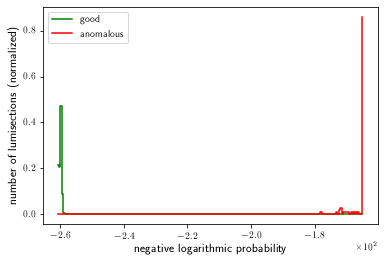

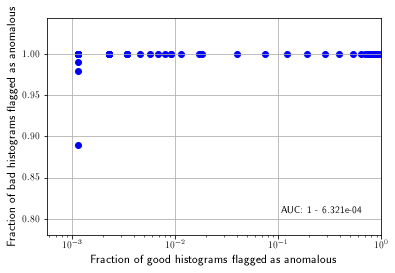

Selected logprob threshold of 255.41455781108812
Accuracy: 0.998861047835991
Precision: 0.9977272727272726
Recall: 1.0
F-Measure: 0.9999943194728472
Evaluating Combine:


/tmp/ipykernel_306616/688802665.py:12: RuntimeWarning: divide by zero encountered in log
  logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]


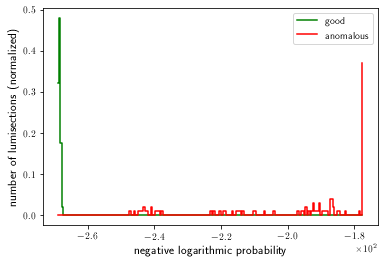

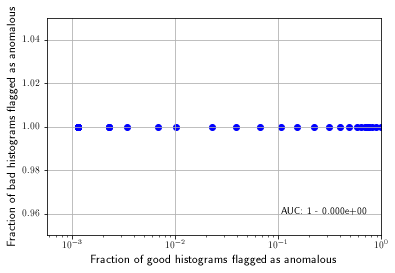

Selected logprob threshold of 265.0140972015916
Accuracy: 0.9994305239179955
Precision: 0.9988623435722412
Recall: 1.0
F-Measure: 0.9999971597283565
Evaluating 1D Mash:


/tmp/ipykernel_306616/688802665.py:12: RuntimeWarning: divide by zero encountered in log
  logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]


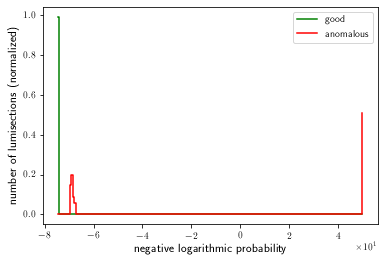

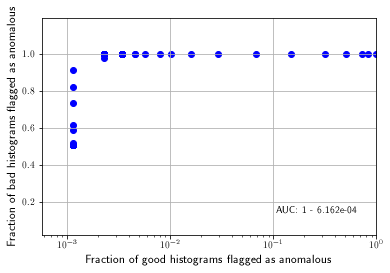

Selected logprob threshold of 71.43300396766193
Accuracy: 0.9988674971687429
Precision: 0.9977401129943503
Recall: 1.0
F-Measure: 0.9999943516387307
Final Speed Metrics:
Preprocess time:
   - Concatamash: 4.24591000052169
   - Combined: 4.24591000052169
   - 1DMash: 55.97888481197879
Training time:
   - Concatamash: 43.6755533288233
   - Combined: 122.69614552520216
   - 1DMash: 46.308811977971345


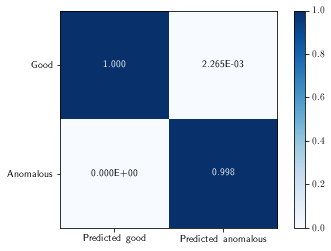

In [24]:
main(start, histstruct, histstruct2, biasFactor)